In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# All the functions related to section b

bin = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(jobs)] ) )
def calc_cost_per_state(problem_table, state):
    in_jobs = bin(state)
    in_jobs=in_jobs[::-1]
    cost = 0
    for idx, job in enumerate(in_jobs):
        if int(job):
            cost += problem_table[1, idx]
    return cost

def calc_p(problem_table, policy):
    P = np.zeros([states, states])
    for row in range(states):
        for col in range(states):
            curr_state = row
            next_state = col
            if curr_state > 0:
                possible_next_state = curr_state - 2 ** (int(policy[curr_state]) - 1)
            if curr_state == 0:
                if next_state == 0:
                    P[row,col] = 1
                else:
                    P[row,col] = 0
                continue
            if next_state == possible_next_state:
                P[row,col] = problem_table[0, int(policy[curr_state]) - 1]
            elif next_state == curr_state:
                P[row,col] = 1 - problem_table[0, int(policy[curr_state]) - 1]
            else:
                P[row,col] = 0
    return P  

def get_v(p, r):
    p[0][0] = 0
    return np.dot(np.linalg.inv(np.identity(len(r))-p), r)

def get_v_iteration(p, r):
    v = np.ones([len(r)])
    v_new = np.zeros([len(r)])
    while not (v == v_new).all():
        v = v_new.copy()
        v_new = r + p @ v
    return v

In [3]:
# policies defintions

def get_policy_c(table, state):
    in_jobs = bin(state)
    in_jobs=in_jobs[::-1]
    max_c = -1
    max_idx = -1
    for idx, job in enumerate(in_jobs):
        if int(job):
            cost = problem_table[1, idx]
            if cost > max_c:
                max_c = cost
                max_idx = idx
    return max_idx+1

def get_policy_uc(table, state):
    in_jobs = bin(state)
    in_jobs=in_jobs[::-1]
    max_c = -1
    max_idx = -1
    for idx, job in enumerate(in_jobs):
        if int(job):
            cost = problem_table[1, idx] * problem_table[0, idx]
            if cost > max_c:
                max_c = cost
                max_idx = idx
    return max_idx+1

def get_policy_rand(table, state):
    in_jobs = bin(state)
    in_jobs=in_jobs[::-1]
    while True:
        rand_job = np.random.randint(len(in_jobs))
        if int(in_jobs[rand_job]):
            break
    return rand_job+1

def get_full_policy_uc(table):
    num_states = 2 ** (len(table[0]))
    policy = np.zeros(num_states)
    for state in range(num_states):
        policy[state] = get_policy_uc(table, state)
    return policy

def get_full_policy_c(table):
    num_states = 2 ** (len(table[0]))
    policy = np.zeros(num_states)
    for state in range(num_states):
        policy[state] = get_policy_c(table, state)
    return policy


def get_full_policy_rand(table):
    num_states = 2 ** (len(table[0]))
    policy = np.zeros(num_states)
    for state in range(num_states):
        if state == 0:
            policy[state] = 0
            continue
        policy[state] = get_policy_rand(table, state)
    return policy

In [4]:
# calc policy iteration related

def is_action_valid(state, action):
    in_jobs = bin(state)
    in_jobs=in_jobs[::-1]
    return bool(int(in_jobs[action-1]))

def get_temp_p(state, action):
    p = np.zeros([2 ** jobs])
    possible_next_state = state - 2 ** (action - 1)
    p[possible_next_state] = problem_table[0, action - 1]
    p[state] = 1 - problem_table[0, action - 1]
    return p

def get_new_policy(r, v):
    num_states = 32
    policy = np.zeros([num_states])
    for state in range(num_states):
        min_action_val = 10000000
        min_action = -1
        for a in range(1,jobs+1):
            if is_action_valid(state=state, action=a):
                val = r[state]+get_temp_p(state=state, action=a) @ v
                if val < min_action_val:
                    min_action_val = val
                    min_action = a
        policy[state] = min_action
    return policy

def policy_iteration(r, table):
    num_states = 2 ** len(table[0])
    new_policy = np.zeros([num_states])
    for state in range(num_states):
        new_policy[state] = get_policy_c(table=table, state=state)
    policy = np.zeros([num_states])
    while not (new_policy == policy).all():
        #print("*"*20)
        #print(new_policy)
        policy = new_policy.copy()
        p = calc_p(problem_table=table, policy=policy)
        v = get_v_iteration(p=p, r=r)
        #print(v)
        new_policy = get_new_policy(r=r, v=v)
    return policy
        

In [5]:
jobs = 5
states = 2 ** jobs
cost = np.zeros([states])
problem_table = np.array([
    [0.6, 0.5, 0.3, 0.7, 0.1],
    [1,     4,   6,   2,   9]
])

for state in range(states):
    cost[state] = calc_cost_per_state(problem_table=problem_table, state=state)


In [6]:
# section B
policy = get_full_policy_uc(table=problem_table)
p = calc_p(problem_table, policy)
get_v_iteration(p=p, r=cost)
get_v(p=p, r=cost)

array([  0.        ,   1.66666667,   8.        ,  11.66666667,
        20.        ,  25.        ,  40.        ,  47.        ,
         2.85714286,   5.95238095,  14.85714286,  19.95238095,
        29.52380952,  35.95238095,  53.52380952,  61.95238095,
        90.        , 101.66666667, 116.        , 129.66666667,
       140.        , 155.        , 178.        , 195.        ,
       105.71428571, 118.80952381, 135.71428571, 150.80952381,
       162.38095238, 178.80952381, 204.38095238, 222.80952381])

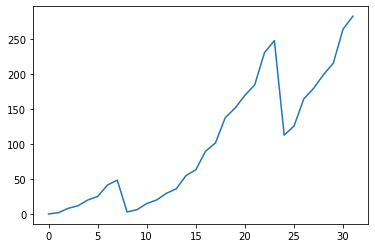

In [7]:
# section C
policy = get_full_policy_c(table=problem_table)
p = calc_p(problem_table, policy)
get_v_iteration(p=p, r=cost)
V_c = get_v(p=p, r=cost)
plt.plot(V_c)
plt.show()

Policy Iteration: 
 [-1.  1.  2.  2.  3.  3.  2.  2.  4.  4.  2.  2.  3.  3.  2.  2.  5.  5.
  2.  2.  3.  3.  2.  2.  4.  4.  2.  2.  3.  3.  2.  2.]
uc by definition: 
 [0. 1. 2. 2. 3. 3. 2. 2. 4. 4. 2. 2. 3. 3. 2. 2. 5. 5. 2. 2. 3. 3. 2. 2.
 4. 4. 2. 2. 3. 3. 2. 2.]


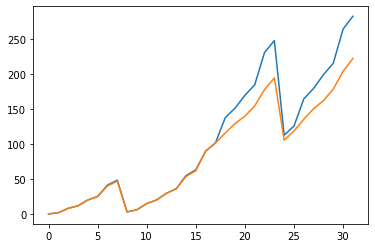

In [8]:
# section d + e
print("Policy Iteration: \n", policy_iteration(r=cost, table=problem_table))
print("uc by definition: \n", get_full_policy_uc(table=problem_table))

policy = get_full_policy_uc(table=problem_table)
p = calc_p(problem_table, policy)
V_uc = get_v(p=p, r=cost)

plt.plot(V_c)
plt.plot(V_uc)
plt.show()

In [17]:
#section f Simulator
def single_step_sim(state, action, table):
    cost = calc_cost_per_state(problem_table=table, state=state)
    miu=problem_table[0][int(action-1)]
    finished = np.random.binomial(1, miu)
    if bool(finished):
        new_state = state - 2 ** (action-1)
    else:
        new_state = state
    return cost, new_state
    
def get_next_state(state, action, miu):
    finished = np.random.binomial(1, miu)
    #print("is done:",finished)
    if bool(finished):
        #print("done")
        new_state = state - 2 ** (action-1)
    else:
        #print("not done")
        new_state = state
    #print("new_state", new_state)
    return new_state

def simulation(policy, table, random=False):
    if random:
        curr_state = int(np.random.randint(32))
    else:
        curr_state = 2 ** len(table[0]) -1
    total_cost = 0
    trajectories = []
    while not curr_state == 0:
        curr_cost = calc_cost_per_state(problem_table=table, state=curr_state)
        curr_action = policy[curr_state]
        #print("="*10)
        #print("state:",bin(curr_state)[::-1])
        #print("action:", curr_action)
        new_state = get_next_state(state=curr_state, action=curr_action, miu=problem_table[0][int(curr_action-1)])
        total_cost += curr_cost
        new_sample = (int(curr_state), int(curr_action), int(curr_cost), int(new_state))
        curr_state = int(new_state)
        #print("cost:", total_cost)
        trajectories.append(new_sample)
        
    return total_cost, trajectories

In [21]:
# section g
def update_TD_zero(estimated_v, alpha, gamma, sample):
    s_t, a_t, r_t, s_tag = sample
    v_s_t = estimated_v[s_t]
    v_s_tag = estimated_v[s_tag]
    delta_t = r_t + gamma * v_s_tag - v_s_t
    updated_v = estimated_v.copy()
    updated_v[s_t] = estimated_v[s_t] + alpha * delta_t
    return updated_v

N = 100000

v = np.zeros([32])
for i in range(N):
    cost, trajectory = simulation(policy=get_full_policy_c(table=problem_table), table=problem_table, random=True)
    for sample in trajectory:
        alpha = 0.01
        v = update_TD_zero(estimated_v=v, alpha=alpha, gamma=1, sample=sample)
print("*"*20)
print("TD(0) alpha=0.01 for policy_c:\n", np.round(v,3))

v = np.zeros([32])
n = np.zeros([32])
for i in range(N):
    cost, trajectory = simulation(policy=get_full_policy_c(table=problem_table), table=problem_table, random=True)
    for sample in trajectory:
        s_t, _, _, _ = sample
        n[s_t] += 1
        alpha = 1/n[s_t]
        v = update_TD_zero(estimated_v=v, alpha=alpha, gamma=1, sample=sample)
print("*"*20)
print("TD(0) alpha=1/n for policy_c:\n", np.round(v,3))
        
v = np.zeros([32])
n = np.zeros([32])
for i in range(N):
    cost, trajectory = simulation(policy=get_full_policy_c(table=problem_table), table=problem_table, random=True)
    for sample in trajectory:
        s_t, _, _, _ = sample
        n[s_t] += 1
        alpha = 10/(100 + n[s_t])
        v = update_TD_zero(estimated_v=v, alpha=alpha, gamma=1, sample=sample)
print("*"*20)
print("TD(0) alpha=10/(100+n) for policy_c:\n", np.round(v,3))
        
print("*"*20)
print("V of policy_c:\n", np.round(V_c,3))

********************
TD(0) alpha=0.01 for policy_c:
 [  0.      1.626   8.581  11.424  19.068  23.803  40.726  45.309   2.836
   5.846  13.977  19.303  31.334  32.835  52.662  60.695  95.308 104.134
 135.84  150.054 191.463 180.502 236.204 237.426 107.4   144.103 168.722
 190.791 199.239 220.856 262.657 253.446]
********************
TD(0) alpha=1/n for policy_c:
 [  0.      1.665   8.009  11.586  18.766  24.106  39.028  45.828   2.855
   5.928  14.793  19.8    28.14   33.651  53.143  59.54   58.199  65.511
  90.828 103.357 106.904 117.818 148.19  153.367  76.189  89.348 108.005
 119.72  128.143 138.037 166.651 177.272]
********************
TD(0) alpha=10/(100+n) for policy_c:
 [  0.      1.661   7.999  11.581  19.634  24.792  42.305  48.244   2.851
   5.921  14.871  19.823  29.435  35.707  55.175  62.936  89.007  99.405
 138.911 151.626 174.179 186.407 228.204 249.909 110.942 122.936 163.311
 178.145 200.889 218.8   258.897 279.408]
********************
V of policy_c:
 [  0.      1.667

In [ ]:
# section h
def update_eligibilty_traces(eligibilty, sample, lamda, gamma):
    s_t, a_t, r_t, s_tag = sample
    eligibilty = eligibilty * lamda * gamma
    eligibilty[s_t] = eligibilty[s_t] + 1
    return eligibilty
    
def calc_delta_t(sample, v, gamma):
    s_t, a_t, r_t, s_tag = sample
    delta = r_t + gamma*v[s_tag] - v[s_t]
    return delta
    
def update_v_TD_lambda(estimated_v, eligibility ,alpha, delta_t):
    return estimated_v + alpha * eligibility * delta_t

v = np.zeros([32])
e = np.zeros([32])
n = np.zeros([32])
N = 1000
for i in range(N):
    cost, trajectory = simulation(policy=get_full_policy_c(table=problem_table), table=problem_table)
    for sample in trajectory:
        s_t, _, _, _ = sample
        n[s_t] += 1
        alpha = 10/(1 + n[s_t])
        delta = calc_delta_t(sample=sample, v=v, gamma=1.0)
        e = update_eligibilty_traces(eligibilty=e, sample=sample, lamda=0.1, gamma=1.0)
        v = update_TD_zero(estimated_v=v, alpha=alpha, gamma=1, sample=sample)
        
print("*"*20)
print("TD(lambda) alpha=10/(100+n) for policy_c:\n", np.round(v,3))
        
print("*"*20)
print("V of policy_c:\n", np.round(V_c,3))

In [ ]:
# section i
def get_action_min(state, Q, epsilon):     # 1-5
    if state == 0:
        return 0
    greedy = np.random.binomial(1, 1-epsilon)
    if greedy:
        #print("greedy", end='-')
        min_a = np.inf
        min_idx = -1
        for a in range(5):
            if is_action_valid(state=state, action=a+1):
                if Q[state, a] < min_a:
                    min_a = Q[state, a]
                    min_idx = a+1
        #print("choosen action:", max_idx)
        return min_idx
    
    #print("random", end='-')
    rand_act = int(np.random.randint(5))+1
    while not is_action_valid(state=state, action=rand_act):
        rand_act = int(np.random.randint(5))+1
    #print("choosen action:", rand_act)
    return rand_act



Q = 1000*np.ones([32,5])
epsilon = 1
n = np.zeros([32,5])

N = 100_000
for i in range(N):
    #print("*"*10)
    state_t = 31
    action_t = get_action_min(state=state_t, Q=Q, epsilon=epsilon)
    while not state_t == 0:
        cost_t, state_tag = single_step_sim(state=state_t, action=action_t, table=problem_table)
        #print("state:", state_t, ", action:", action_t, ", next_state:", state_tag)
        
        f_epsilon = epsilon /((i+1)**0.7)
        action_tag = get_action_min(state=state_tag, Q=Q, epsilon=f_epsilon)
        reward = cost_t
        
        delta = reward + 1 * Q[state_tag, action_tag-1] - Q[state_t, action_t-1]
        
        n[state_t, action_t-1] = n[state_t, action_t-1] + 1
        alpha = 10/(100+n[state_t, action_t-1])
        #alpha = 0.1
        
        Q[state_t, action_t-1] = Q[state_t, action_t-1] + alpha * delta
        
        state_t = state_tag
        action_t = action_tag

Q = Q - 1000
print(np.round(Q, 3))
 

In [ ]:
final_Q = Q + 1000*(Q==0)
final_Q[0,0] = 0
print((np.argmin(final_Q, axis=1)+1)[1:] == get_full_policy_uc(table=problem_table)[1:])
print(31 - ((np.argmin(final_Q, axis=1)+1)[1:] == get_full_policy_uc(table=problem_table)[1:]).sum())

In [ ]:
print(np.min(final_Q, axis=1))

In [ ]:
V_uc

In [ ]:
print(np.max(V_uc - np.min(final_Q, axis=1)))

In [16]:
np.random.randint(2)

1